# DTW* v0.2a

In [2]:
import numpy as np
from numba import jit

In [3]:
%matplotlib inline
%load_ext Cython

In [4]:
@jit(nopython=True)
def dtwstar_v2a(C, steps, weights, buffer=1):
    '''
    Implementation of DTW Star version 0.2a.  
    
    Inputs
    C: pairwise cost matrix
    steps: a numpy matrix specifying the allowable transitions.  It should be of
        dimension (L, 2), where each row specifies (row step, col step)
    weights: a array that specifies the multiplicative weights for each transition
        type.  The length of this array must match the number of possible transitions.
    buffer: specifies 
    
    Outputs
    best_cost: the best average cost per manhattan block
    path: the estimated warping path, specified as a 2xN array
    debug: Debugging information for examining the average cost per manhattan block for each 
        of the candidate ending positions.
    '''
    
    # initialize
    D = np.zeros(C.shape)
    B = np.zeros(C.shape, dtype=np.int8)
    P = np.zeros(C.shape, dtype=np.int32)
    D[0,:] = C[0,:]
    D[:,0] = C[:,0]
    
    # DP
    for row in range(1,C.shape[0]):
        for col in range(1, C.shape[1]):
            
            mincost = np.inf
            minidx = -1
            bestrprev = -1
            bestcprev = -1
            
            # find best transition
            for stepidx, step in enumerate(steps):
                
                (rstep, cstep) = step
                prevrow = row - rstep
                prevcol = col - cstep
                
                if prevrow >= 0 and prevcol >= 0:
                    
                    pathcost = D[prevrow, prevcol] + C[row, col] * weights[stepidx]
                    
                    if pathcost < mincost:
                        
                        mincost = pathcost
                        minidx = stepidx
                        bestrprev = prevrow
                        bestcprev = prevcol
            
            # update D, B, P
            D[row, col] = mincost
            B[row, col] = minidx
            if bestrprev == 0:
                P[row, col] = bestcprev
            elif bestcprev == 0:
                P[row, col] = -1*bestrprev
            else:
                P[row, col] = P[bestrprev, bestcprev]
            
    #  backtrack
    best_cost, best_r, best_c, debug = find_best_endpoint(D, P, buffer)
    path = backtrace_dtwstar(D, B, steps, best_r, best_c)
    path.reverse()
    path = np.array(path).T 
    
    return best_cost, path, debug, D, B, P

In [5]:
@jit(nopython=True)
def find_best_endpoint(D, P, buffer):
    '''
    Determines the best location to begin backtracking from by comparing the average path cost
    per manhattan block.
    
    Inputs
    D: the cumulative cost matrix
    P: the matrix specifying the starting location of the alignment path
    buffer: specifies the length of a buffer region (in frames) to avoid short degenerate alignment paths
        near the corners of the pairwise cost matrix.  This can be thought of as the minimum length that
        needs to match in order to be considered a valid alignment path.
    
    Outputs
    best_cost: the best average path cost per manhattan block
    best_r: the row index of the best endpoint
    best_c: the column index of the best endpoint
    debug: debugging information for examining the average cost per manhattan block for each 
        of the candidate ending positions
    '''
    
    # consider last row and column as candidates
    candidates = [(D.shape[0]-1,i) for i in range(buffer, D.shape[1])] + [(i, D.shape[1]-1) for i in range(buffer, D.shape[0]-1)][::-1]
    
    best_cost = np.inf
    best_r, best_c = -1, -1
    debug = []
    
    for i, (r,c) in enumerate(candidates):
                
        # get alignment start location
        if P[r,c] >= 0:
            rstart, cstart = 0, P[r,c]
        else:
            rstart, cstart = -P[r,c], 0
            
        # calculate average cost per manhattan block
        mdist = (r - rstart) + (c - cstart) # manhattan distance
        avg_cost_per_mb = D[r,c] / mdist
        
        # keep best
        if avg_cost_per_mb < best_cost:
            best_cost = avg_cost_per_mb
            best_r, best_c = r, c
            
        # debugging info
        if r == D.shape[0]-1:
            debug.append((c-D.shape[1]+1, avg_cost_per_mb, r, c))
        else:
            debug.append((D.shape[0]-1-r, avg_cost_per_mb, r, c))
    
    return best_cost, best_r, best_c, debug

In [6]:
@jit(nopython=True)
def backtrace_dtwstar(D, B, steps, rstart, cstart):
    '''
    Backtraces through the cumulative cost matrix D starting from a specified location.
    
    Arguments:
    D: cumulative cost matrix
    B: backtrace matrix
    steps: a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    rstart: the row index to start backtracking from
    cstart: the column index to start backtracking from
    
    Outputs
    path: a python list of (row, col) coordinates for the optimal path.
    '''
    pos = (rstart, cstart)
    path = []
    path.append(pos)
    while(pos[0] != 0 and pos[1] != 0):
        (row, col) = pos
        stepidx = B[row, col]
        (rstep, cstep) = steps[stepidx]
        pos = (row-rstep, col-cstep)
        path.append(pos)
    
    return path

# Visualize

The code below can be used to run DTW* v0.2a on specific examples, and to visualize the alignments.

In [7]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt
import time
import pandas as pd

In [9]:
def L2norm(F):
    L2norm = np.sqrt(np.sum(F*F, axis = 0)) + 1e-9
    Fnorm = F / L2norm.reshape((1,-1))
    return Fnorm

In [10]:
# def getTimestamps(annotfile1, annotfile2):
#     df1 = pd.read_csv(annotfile1, header=None, sep='\s+', skiprows=3) 
#     df2 = pd.read_csv(annotfile2, header=None, sep='\s+', skiprows=3)
    
#     df_merged = pd.merge(df1, df2, on=[2], how='inner')

#     return np.array(df_merged['0_x']), np.array(df_merged['0_y'])

In [11]:
# def mapFrame(r, c, Dshape, frames=False):
#     if frames: #  frames, use exact
#         if r == Dshape[0]-1:
#             val = c-D.shape[1]+1
#         else:
#             val = D.shape[0]-1-r
#     else: # seconds, use approximate
#         distr = np.abs(r-Dshape[0])
#         distc = np.abs(c-Dshape[1])
#         if distr < distc:
#             val = c-Dshape[1]
#         else:
#             val = Dshape[0]-r
#     return val

In [12]:
# pieceid1 = 'Chopin_Op017No4_Beliavsky-2004_pid9152-13'
# #pieceid1 = 'Chopin_Op017No4_Luisada-1990_pid9055-13'
# #pieceid1 = 'Chopin_Op017No4_Kilenyi-1937_pid9164-13'
# #pieceid1 = 'Chopin_Op017No4_Magaloff-1977_pid5667267b-10'
# #pieceid1 = 'Chopin_Op017No4_Wasowski-1980_pid9111-13'
# type1 = 'partialStart'
# pieceid2 = 'Chopin_Op017No4_Clidat-1994_pid9067-13'
# #pieceid2 = 'Chopin_Op017No4_Paderewski-1912_pid5667274-09'
# #pieceid2 = 'Chopin_Op017No4_Rubinstein-1939_pid9049-13'
# #pieceid2 = 'Chopin_Op017No4_Smith-1975_pid9054-13'
# #pieceid2 = 'Chopin_Op017No4_Perahia-1994_pid54293-09'
# type2 = 'partialEnd'
# steps = np.array([1, 1, 1, 2, 2, 1]).reshape((-1,2))
# weights = np.array([2,3,3])
# hop_sec = 512/22050.
# buffer = 10 # in sec

In [13]:
# featfile1 = f'/home/tjtsai/ttmp/Chopin_Mazurkas_features/{type1}/Chopin_Op017No4/{pieceid1}.npy'
# featfile2 = f'/home/tjtsai/ttmp/Chopin_Mazurkas_features/{type2}/Chopin_Op017No4/{pieceid2}.npy'
# F1 = np.load(featfile1)
# F2 = np.load(featfile2)

In [14]:
# if type1 == 'original':
#     annotfile1 = f'/home/tjtsai/ttmp/Chopin_Mazurkas_Modified/annotations_beat/Chopin_Op017No4/{pieceid1}.beat'
# else:
#     annotfile1 = f'/home/tjtsai/ttmp/Chopin_Mazurkas_Benchmarks/{type1}/annotations_beat/Chopin_Op017No4/{pieceid1}.beat'
# if type2 == 'original':
#     annotfile2 = f'/home/tjtsai/ttmp/Chopin_Mazurkas_Modified/annotations_beat/Chopin_Op017No4/{pieceid2}.beat'
# else:
#     annotfile2 = f'/home/tjtsai/ttmp/Chopin_Mazurkas_Benchmarks/{type2}/annotations_beat/Chopin_Op017No4/{pieceid2}.beat'
# gt1, gt2 = getTimestamps(annotfile1, annotfile2)

3.723769187927246 seconds


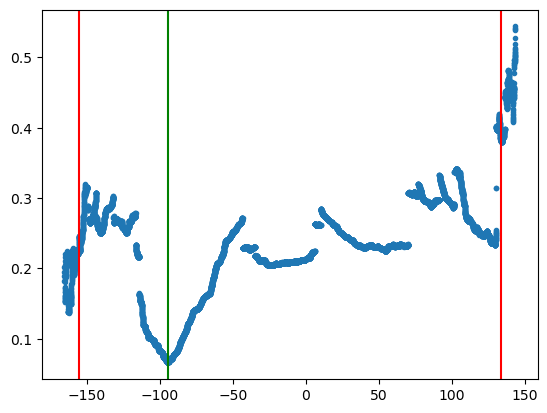

In [38]:
# C = 1 - L2norm(F1).T @ L2norm(F2)
# start = time.time()
# best_cost, wp, debug, _, _, _ = dtwstar_v2a(C, steps, weights, buffer/hop_sec)
# print("% s seconds" % (time.time() - start))
# X = np.array(debug)
# times = X[:,0]*hop_sec
# scores = X[:,1]
# plt.plot(times, scores,'.')
# plt.axvline(times.min()+10, color='r')
# plt.axvline(times.max()-10, color='r')
# plt.axvline(mapFrame(gt1[-1], gt2[-1], (F1.shape[1]*hop_sec, F2.shape[1]*hop_sec)), color='g')

(0.0, 168.57995464852607)

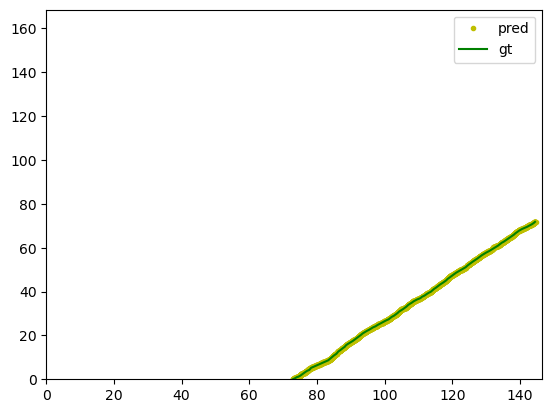

In [39]:
# plt.plot(wp[0,:]*hop_sec, wp[1,:]*hop_sec, 'y.')
# plt.plot(gt1, gt2, 'g')
# plt.legend(['pred', 'gt'])
# plt.xlim([0, F1.shape[1]*hop_sec+2])
# plt.ylim([0, F2.shape[1]*hop_sec+2])

# New DTW* v0.2b

In [ ]:
@jit(nopython=True)
def dtwstar_v2b(C, steps, weights, buffer = 1):
    
    # initialize
    D = np.zeros(C.shape)
    B = np.zeros(C.shape, dtype=np.int8)
    P = np.zeros(C.shape, dtype=np.int32)
    D[0,:] = C[0,:]
    D[:,0] = C[:,0]
    
    # DP
    for row in range(1,C.shape[0]):
        for col in range(1, C.shape[1]):
            mincost = np.inf
            minidx = -1
            bestrprev = -1
            bestcprev = -1
            for stepidx, step in enumerate(steps):
                (rstep, cstep) = step
                prevrow = row - rstep
                prevcol = col - cstep
                if prevrow >= 0 and prevcol >= 0:
                    
                    # calculate avg cost per manhattan block
                    pathcost = D[prevrow, prevcol] + C[row, col] * weights[stepidx]
                    if P[prevrow, prevcol] >= 0:
                        mdist = row + (col - P[prevrow, prevcol])
                    else:
                        mdist = (row + P[prevrow, prevcol]) + col
                    cost_per_mb = pathcost / mdist
                    
                    # select best transition based on avg cost per manhattan block
                    if cost_per_mb < mincost:
                        mincost = cost_per_mb
                        minidx = stepidx
                        bestrprev = prevrow
                        bestcprev = prevcol
                        
            D[row, col] = D[bestrprev, bestcprev] + C[row, col] * weights[minidx]
            B[row, col] = minidx
            if bestrprev == 0:
                P[row, col] = bestcprev
            elif bestcprev == 0:
                P[row, col] = -1*bestrprev
            else:
                P[row, col] = P[bestrprev, bestcprev]
            
    #  backtrack
    best_cost, best_r, best_c, debug = find_best_endpoint(D, P, buffer)
    path = backtrace_dtwstar(D, B, steps, best_r, best_c)
    path.reverse()
    path = np.array(path)
    
    return best_cost, path.T, debug

# DTW* v0.2b

Seems to have about same accuracy as v0.2a, but is significantly slower.

In [17]:
# @jit(nopython=True)
# def dtwstar_v2b(C, steps, weights):
    
#     # initialize
#     D = np.zeros(C.shape)
#     B = np.zeros(C.shape, dtype=np.int8)
#     P = np.zeros(C.shape, dtype=np.int32)
#     D[0,:] = C[0,:]
#     D[:,0] = C[:,0]
    
#     # DP
#     for row in range(1,C.shape[0]):
#         for col in range(1, C.shape[1]):
#             mincost = np.inf
#             minidx = -1
#             bestrprev = -1
#             bestcprev = -1
#             for stepidx, step in enumerate(steps):
#                 (rstep, cstep) = step
#                 prevrow = row - rstep
#                 prevcol = col - cstep
#                 if prevrow >= 0 and prevcol >= 0:
                    
#                     # calculate avg cost per manhattan block
#                     pathcost = D[prevrow, prevcol] + C[row, col] * weights[stepidx]
#                     if P[prevrow, prevcol] >= 0:
#                         mdist = row + (col - P[prevrow, prevcol])
#                     else:
#                         mdist = (row + P[prevrow, prevcol]) + col
#                     cost_per_mb = pathcost / mdist
                    
#                     # select best transition based on avg cost per manhattan block
#                     if cost_per_mb < mincost:
#                         mincost = cost_per_mb
#                         minidx = stepidx
#                         bestrprev = prevrow
#                         bestcprev = prevcol
                        
#             D[row, col] = D[bestrprev, bestcprev] + C[row, col] * weights[minidx]
#             B[row, col] = minidx
#             if bestrprev == 0:
#                 P[row, col] = bestcprev
#             elif bestcprev == 0:
#                 P[row, col] = -1*bestrprev
#             else:
#                 P[row, col] = P[bestrprev, bestcprev]
            
#     #  backtrack
#     best_cost, best_r, best_c, debug = find_best_endpoint(D, P)
#     path = backtrace_dtwstar(D, B, steps, best_r, best_c)
#     path.reverse()
#     path = np.array(path)
    
#     return best_cost, path.T, debug

## SubseqDTW and NWTW

Can be used to compare to SubseqDTW and NWTW alignments

In [18]:
#%run _NWTW.ipynb

In [19]:
#%run align_tools_cython.ipynb

In [20]:
# times = []
# times.append(time.time())
# #best_cost, wp, debug = dtwstar_v2a(C, steps, weights, buffer/hop_sec)
# wp1 = alignDTW(L2norm(F1), L2norm(F2), steps=steps, weights=weights, downsample=1, outfile=None, subseq=True)
# times.append(time.time())
# print("SubseqDTW: % s seconds" % (times[1]-times[0]))
# wp2 = alignNWTW(L2norm(F1), L2norm(F2), downsample=1, gamma=0.346, profile = False)
# times.append(time.time())
# print("NWTW: %s seconds" % (times[2] - times[1]))

In [21]:
# plt.plot(wp1[0,:]*hop_sec, wp1[1,:]*hop_sec, 'r')
# plt.plot(wp2[0,:]*hop_sec, wp2[1,:]*hop_sec, 'b')
# plt.plot(gt1, gt2, 'g')
# plt.legend(['dtw','nwtw','gt'])
# plt.xlim([0, F1.shape[1]*hop_sec+2])
# plt.ylim([0, F2.shape[1]*hop_sec+2])
# #plt.xlim([0,50])
# #plt.ylim([0,80])
# #plt.xlim([130,170])
# #plt.ylim([150,200])

## CPython Implementation

In [34]:
# %%cython
# import numpy as np
# cimport numpy as np
# cimport cython

# import sys
# import time


# DTYPE_INT32 = np.int32
# ctypedef np.int32_t DTYPE_INT32_t

# DTYPE_FLOAT = np.float64
# ctypedef np.float64_t DTYPE_FLOAT_t

# cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# # careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
# @cython.boundscheck(False) # turn off bounds-checking for entire function
# def DTWStar2_Cost_To_AccumCostAndSteps(Cin, parameter):
#     '''
#     Inputs
#         C: The cost Matrix
#     '''

#     '''
#     Section for checking and catching errors in the inputs
#     '''

#     cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
#     try:
#         C = np.array(Cin, dtype=DTYPE_FLOAT)
#     except TypeError:
#         print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
#         return [-1, -1, -1]
#     except ValueError:
#         print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
#         return [-1, -1, -1]

#     cdef np.ndarray[np.uint32_t, ndim=1] dn
#     cdef np.ndarray[np.uint32_t, ndim=1] dm
#     cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
#     # make sure dn, dm, and dw are setup
#     # dn loading and exception handling
#     if ('dn'  in parameter.keys()):
#         try:
#             dn = np.array(parameter['dn'], dtype=np.uint32)
#         except TypeError:
#             print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
#             return [-1, -1, -1]
#         except ValueError:
#             print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
#             return [-1, -1, -1]
#     else:
#         dn = np.array([1, 1, 0], dtype=np.uint32)
#     # dm loading and exception handling
#     if 'dm'  in parameter.keys():
#         try:
#             dm = np.array(parameter['dm'], dtype=np.uint32)
#         except TypeError:
#             print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
#             return [-1, -1, -1]
#         except ValueError:
#             print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
#             return [-1, -1, -1]
#     else:
#         print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
#         dm = np.array([1, 0, 1], dtype=np.uint32)
#     # dw loading and exception handling
#     if 'dw'  in parameter.keys():
#         try:
#             dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
#         except TypeError:
#             print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
#             return [-1, -1, -1]
#         except ValueError:
#             print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
#             return [-1, -1, -1]
#     else:
#         dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
#         print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)

#     '''
#     Section where types are given to the variables we're going to use 
#     '''
#     # create matrices to store our results (D and E)
#     cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
#     cdef DTYPE_INT32_t numCols = C.shape[1]
#     cdef DTYPE_INT32_t numDifSteps = np.size(dw)

#     cdef unsigned int maxRowStep = max(dn)
#     cdef unsigned int maxColStep = max(dm)

#     cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
#     cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT
#     cdef np.ndarray[np.int32_t, ndim=2] manhattanDistance = np.zeros((numRows,numCols), dtype=np.int32)

#     cdef DTYPE_FLOAT_t bestCost
#     cdef DTYPE_INT32_t bestCostIndex
#     cdef DTYPE_FLOAT_t costForStep
#     cdef unsigned int row, col
#     cdef unsigned int stepIndex
#     cdef int bestRPrev, bestCPrev

#     # Initialization
#     accumCost[maxRowStep, maxColStep:] = C[0,:]
#     accumCost[maxRowStep:, maxColStep] = C[:,0]

#     # filling the accumulated cost matrix
#     for row in range(maxRowStep + 1, numRows + maxRowStep, 1):
#         for col in range(maxColStep + 1, numCols + maxColStep, 1):
#             bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
#             bestCostIndex = 0
#             bestRPrev = 0
#             bestCPrev = 0
#             # go through each step, find the best one
#             for stepIndex in range(numDifSteps):
                
#                 costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
#                 if costForStep < bestCost:
#                     bestCost = costForStep
#                     bestCostIndex = stepIndex
#                     bestRPrev = <unsigned int> (row - dn[(stepIndex)] - maxRowStep)
#                     bestCPrev = <unsigned int> (col - dm[(stepIndex)] - maxColStep)
#             # save the best cost and best cost index
#             accumCost[row, col] = bestCost
#             steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex
#             if bestRPrev == 0:
#                 manhattanDistance[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCPrev
#             elif bestCPrev == 0:
#                 manhattanDistance[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = -1 * bestRPrev
#             else:
#                 manhattanDistance[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = manhattanDistance[<unsigned int>(bestRPrev), <unsigned int>(bestCPrev)]

#     # return the accumulated cost along with the matrix of steps taken to achieve that cost
#     return [accumCost[maxRowStep:, maxColStep:], steps, manhattanDistance]

# @cython.boundscheck(False) # turn off bounds-checking for entire function
# def DTWStar2_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter, rstart, cstart):
#     '''

#     Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
#     '''

#     cdef np.ndarray[unsigned int, ndim=1] dn
#     cdef np.ndarray[unsigned int, ndim=1] dm
#     # make sure dn, dm, and dw are setup
#     if ('dn'  in parameter.keys()):
#         dn = parameter['dn']
#     else:
#         dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
#     if 'dm'  in parameter.keys():
#         dm = parameter['dm']
#     else:
#         dm = np.array([1, 0, 1], dtype=DTYPE_INT32)

#     cdef np.uint32_t numRows
#     cdef np.uint32_t numCols
#     cdef np.uint32_t curRow
#     cdef np.uint32_t curCol
#     cdef np.uint32_t endCol
#     cdef DTYPE_FLOAT_t endCost

#     numRows = accumCost.shape[0]
#     numCols = accumCost.shape[1]

#     # either start at the far corner (non sub-sequence)
#     # or start at the lowest cost entry in the last row (sub-sequence)
#     # where all of the signal along the row has been used, but only a 
#     # sub-sequence of the signal along the columns has to be used
#     curRow = rstart
#     curCol = cstart

#     endCol = curCol
#     endCost = accumCost[curRow, curCol]

#     cdef np.uint32_t curRowStep
#     cdef np.uint32_t curColStep
#     cdef np.uint32_t curStepIndex


#     cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
#     path[0, 0] = curRow
#     path[1, 0] = curCol

#     cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
#     cdef np.uint32_t stepIndex = 0
#     cdef np.int8_t done = (curRow == 0 or curCol == 0)
#     while not done:
#         # you're done if you've made it to the bottom left (non sub-sequence)
#         # or just the bottom (sub-sequence)
#         # find the step size
#         curStepIndex = stepsForCost[curRow, curCol]
#         curRowStep = dn[curStepIndex]
#         curColStep = dm[curStepIndex]
#         # backtrack by 1 step
#         curRow = curRow - curRowStep
#         curCol = curCol - curColStep
#         # add your new location onto the path
#         path[0, stepsInPath] = curRow
#         path[1, stepsInPath] = curCol
#         stepsInPath = stepsInPath + 1
#         # check to see if you're done
#         done = (curRow == 0 or curCol == 0)

#     # # reverse the path (a matrix with two rows) and return it
#     return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

# @cython.boundscheck(False) # turn off bounds-checking for entire function
# def DTWStar2_FindBestEndpoint(Din, Pin, buffer):

#     cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] D
#     cdef np.ndarray[np.int32_t, ndim=2] P

#     try:
#         D = np.array(Din, dtype=DTYPE_FLOAT)
#         P = np.array(Pin, dtype=np.int32)
#     except TypeError:
#         print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
#         return [-1, -1, -1]
#     except ValueError:
#         print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
#         return [-1, -1, -1]

#     cdef np.ndarray[unsigned int, ndim=1] row_candidates
#     cdef np.ndarray[unsigned int, ndim=1] col_candidates
#     cdef unsigned int index
#     cdef unsigned int num_candidates
#     cdef np.float64_t best_cost
#     cdef np.float64_t avg_cost_per_mb
#     cdef unsigned int best_r, best_c
#     cdef int rstart, cstart
#     cdef unsigned int r, c
#     cdef np.float64_t mdist
#     cdef np.uint32_t lastRow, lastCol

#     lastRow = D.shape[0]-1
#     lastCol = D.shape[1]-1
#     index = 0

#     num_candidates = lastRow + lastCol - buffer

#     row_candidates = np.zeros(num_candidates, dtype=np.uint32)
#     col_candidates = np.zeros(num_candidates, dtype=np.uint32)

#     for i in range(buffer, lastCol):
#         row_candidates[index] = lastRow
#         col_candidates[index] = <unsigned int> i
#         index += 1
#     for i in range(lastRow, buffer - 1, -1):
#         row_candidates[index] = <unsigned int> i
#         col_candidates[index] = lastCol
#         index += 1

    
#     best_cost = np.inf
#     best_r, best_c = -1, -1

#     for i in range(num_candidates):
#         r = row_candidates[i]
#         c = col_candidates[i]
#         # get alignment start location
#         if P[r,c] >= 0:
#             rstart, cstart = 0, P[r,c]
#         else:
#             rstart, cstart = -P[r,c], 0 
#         # calculate average cost per manhattan block
#         mdist = (r - rstart) + (c - cstart) # manhattan distance
#         avg_cost_per_mb = D[r,c] / mdist
        
#         # keep best
#         if avg_cost_per_mb < best_cost:
#             best_cost = avg_cost_per_mb
#             best_r, best_c = r, c

#     return best_cost, best_r, best_c


# class bcolors:
#     HEADER = '\033[95m'
#     OKBLUE = '\033[94m'
#     OKGREEN = '\033[92m'
#     WARNING = '\033[93m'
#     FAIL = '\033[91m'
#     ENDC = '\033[0m'
#     BOLD = '\033[1m'
#     UNDERLINE = '\033[4m'

In file included from /home/jzhang/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /home/jzhang/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/jzhang/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/jzhang/.cache/ipython/cython/_cython_magic_e85e1f02daea5d74fbe7cadc952bd831.c:770:
/home/jzhang/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
/home/jzhang/.cache/ipython/cython/_cython_magic_e85e1f02daea5d74fbe7cadc952bd831.c: In function ‘__pyx_pf_46_cython_magic_e85e1f02daea5d74fbe7cadc952bd831_DTWStar2_Cost_To_AccumCostAndSteps’:
/home/jzhang/.cache/ipython/c

In [23]:
# def alignDTWStar2(F1, F2, steps, weights, downsample, buffer=1, C_in=None):
#     # if C_in is not None:
#     #     C = C_in
#     # else:
#     C = 1 - F1[:,0::downsample].T @ F2[:,0::downsample] # cos distance metric
    
#     dn = steps[:,0].astype(np.uint32)
#     dm = steps[:,1].astype(np.uint32)
#     parameters = {'dn': dn, 'dm': dm, 'dw': weights}
#     [D, s, P] = DTWStar2_Cost_To_AccumCostAndSteps(C, parameters)
#     [bestCost, bestRow, bestCol] = DTWStar2_FindBestEndpoint(D, P, buffer)
#     [wp, endCol, endCost] = DTWStar2_GetPath(D, s, parameters, bestRow, bestCol)

# #     if outfile:
# #         pickle.dump(wp, open(outfile, 'wb'))
#     return wp
    
# #     if profile:
# #         return wp, np.diff(times)
# #     else:
# #         return wp

In [24]:
# steps = np.array([1, 1, 1, 2, 2, 1]).reshape((3,2))
# weights = np.array([2,3,3], dtype=np.uint32)
# dn = steps[:,0].astype(np.uint32)
# dm = steps[:,1].astype(np.uint32)
# parameters = {'dn': dn, 'dm': dm, 'dw': weights}
# buffer = 1
# C = np.random.randint(5, size=(20,20))
# [D_1, s, P_1] = DTWStar2_Cost_To_AccumCostAndSteps(C, parameters)
# best_cost, path, debug, D_2, B, P_2 = dtwstar_v2a(C, steps, weights, buffer=1)
# assert(np.array_equal(D_1, D_2))
# assert(np.array_equal(s,B))
# assert(np.array_equal(P_1, P_2))
# print("DTWStar2_Cost_To_AccumCostAndSteps Correct")
# [bestCost, bestRow, bestCol] = DTWStar2_FindBestEndpoint(D_1, P_1, buffer)
# bestCost_T, bestRow_T, bestCol_T, _ = find_best_endpoint(D_1, P_1, buffer)
# assert(bestCost == bestCost_T)
# assert(bestRow == bestRow_T)
# assert(bestCol == bestCol_T)
# print("DTWStar2_FindBestEndpoint Correct")

# [wp, endCol, endCost] = DTWStar2_GetPath(D_1, s, parameters, bestRow, bestCol)
# assert(np.array_equal(wp, path))
# print("DTWStar2_GetPath Correct")



DTWStar2_Cost_To_AccumCostAndSteps Correct
DTWStar2_FindBestEndpoint Correct
DTWStar2_GetPath Correct


In [25]:
# from timeit import default_timer as timer

In [36]:
# C = np.random.randint(10, size=(10000,10000))
# start_p = timer()
# best_cost, path, debug, D_2, B, P_2 = dtwstar_v2a(C, steps, weights)
# end_p = timer()
# start_c = timer()
# wp = alignDTWStar2(None, None, steps, weights, 1, buffer=1, C_in=C)
# end_c = timer()
# assert(np.array_equal(wp, path))
# print("Python time on 10000x10000:", end_p - start_p)
# print("CPython time on 10000x10000:", end_c - start_c)

Python time on 10000x10000: 3.5304324720054865
CPython time on 10000x10000: 3.6062874644994736
